# 肩の高さ・位置を指摘する

In [63]:
# 画像を受け取り
# 正常・傾き・回転・検出失敗のフラグを返す

In [64]:
# 補助線を描画すること
# 背景を0にする（消す）
# 頭頂部で区切る->最初の線
# 顔より下
# 顔幅+1.5までのx軸

In [65]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [81]:
def detect_shoulder(image_path):
    detect_area = [250, 600, 400, 100]
    gray_image = remove_background(image_path)
    resized_image, gray_image = color_to_gray(gray_image) # グレースケール変換
#     thresh = to_thresh_binary_inv(gray_image) # 閾値
#     median = cv2.medianBlur(thresh,7) # ごま塩ノイズ
#     blur = cv2.GaussianBlur(thresh,(5,5),0)
    canny_image = cv2.Canny(gray_image, 50, 110) # エッジ変換 
#     detect_area = face_detect(image_path, resized_image) # 顔検出
    lines = hough_lines_p(resized_image, canny_image, detect_area) # ハフ変換
    result = judge_shoulder(lines, resized_image, detect_area) # 結果取得
    return result

# 画像サイズを整える

In [3]:
def get_resize_rate(width, height):
    if width > 2000 or height > 2000:
        x_rate = 0.15
        y_rate = 0.15
    elif width > 1000 or height > 1000:
        x_rate = 0.5
        y_rate = 0.5
    else:
        x_rate = 1
        y_rate = 1
    return x_rate, y_rate

# 画像を読み込む
# グレースケールに変換する

In [83]:
def color_to_gray(img):
#     raw_image = cv2.imread(input_path)
#     height, width, channels = raw_image.shape[:3]
#     x_rate, y_rate = get_resize_rate(width, height)
#     resized_image = cv2.resize(raw_image, dsize=None, fx=x_rate, fy=y_rate)
    gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img, gray_image

In [5]:
resized_image, gray_image = color_to_gray('./data/images/image.jpg')
print(gray_image.shape)

(307, 230)


In [6]:
# 読み込みと同時にグレースケール変換
# gray_image = cv2.imread('./data/images/image.jpg',cv2.IMREAD_GRAYSCALE)

In [7]:
# グレースケール画像を保存する 
# cv2.imwrite('./data/images/output.jpg', gray_image)

# 閾値でパキッと

In [8]:
def to_thresh_binary_inv(gray_image):
    ret,thresh = cv2.threshold(gray_image,110,255,cv2.THRESH_BINARY_INV)
    return thresh
#     plt.imshow(thresh,'gray')

In [9]:
np.shape(thresh)

NameError: name 'thresh' is not defined

In [ ]:
# THRESH_BINARY: パキッと
# _INV: openCV は背景が黒、物体が白なので反転する

# エッジ変換

In [10]:
def to_canny_img(gray_image):
    canny_image = cv2.Canny(gray_image, 50, 110)
    plt.imshow(canny_image)

In [11]:
gray_image = color_to_gray('./data/images/image.jpg')
to_canny_img(gray_image)

TypeError: Required argument 'threshold2' (pos 4) not found

# 輪郭検出

In [12]:
def detect_contours(input_path):
    resized_image, gray_image = color_to_gray(input_path)
    ret,thresh = cv2.threshold(gray_image,115,255,cv2.THRESH_BINARY_INV)
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     # 小さい輪郭は除く
    contours = list(filter(lambda x: cv2.contourArea(x) >3000, contours))
    cv2.drawContours(resized_image, contours, -1, (0, 255, 0), 2)
    plt.imshow(resized_image)

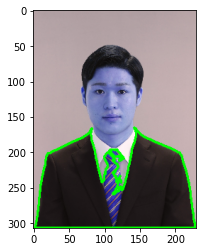

In [13]:
detect_contours('./data/images/image.jpg')

In [14]:
# image = cv2.drawContours(mono_image, contours, -1, (0,255,0), 3)

## 輪郭近似

In [15]:
# 輪郭描画
# for i in range(len(contours)):
#     if hierarchy[0][i][3] == -1:
#         cv2.drawContours(resized_image, contours, i, (0, 255, 0), 2)
# plt.imshow(resized_image)

In [16]:
# cnt = contours[0]
# epsilon = 0.5*cv2.arcLength(cnt,True)
# approx = cv2.approxPolyDP(cnt,epsilon,True)

In [17]:
# cv2.drawContours(resized_image, [approx], -1, (0, 255, 0), 2)
# plt.imshow(resized_image)

# 直線検出

## 直線検出条件

In [93]:
def detect_area_line(line, resized_image, detect_area):
#     print(detect_area)
    x1, y1, x2, y2 = line
    xa = (x2-x1)
    ya = (y2-y1)
    # 画面サイズを取得
    height, width, channels = resized_image.shape[:3]

    # 画面サイズ半分以上の直線を除く
    if xa > (width/2):
        return "false"
    # 上部の直線を除く
    if y1<detect_area[0] or y2<detect_area[0]:
        return "false"
    # 右部の直線を除く
    if x1>detect_area[1] or x2>detect_area[1]:
        return "false"
    # 下部の直線を除く
    if y1>detect_area[2] or y2>detect_area[2]:
        return "false"
    # 左部の直線を除く
    if x1<detect_area[3] or x2<detect_area[3]:
        return "false"
    # x方向に短すぎる直線を除く
    if xa < 50:
        return "false"
    return "true"

## 確率的ハフ変換で直線を抽出

In [19]:
def hough_lines_p(resized_image, canny_image, detect_area):
    # 画面サイズを取得
    height, width, channels = resized_image.shape[:3]
    lines = cv2.HoughLinesP(canny_image, rho=1, theta=np.pi/360, threshold=45, minLineLength=40, maxLineGap=30)
    # 各直線
    for line in lines:
        x1, y1, x2, y2 = line[0]
        xa = (x2-x1)
        ya = (y2-y1)
        
        # 描画条件
        is_range = detect_area_line(line[0], resized_image, detect_area)
        if is_range=="true":
            cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2) # 描画
            
    plt.imshow(resized_image)
    return lines

## ハフ変換で直線を抽出する関数

In [20]:
def hough_lines(input_path):
    raw_image = cv2.imread(input_path)
    resized_image = cv2.resize(raw_image, dsize=None, fx=0.15, fy=0.15)
    gray_image = cv2.cvtColor(resized_image,cv2.COLOR_BGR2GRAY)
    canny_image = cv2.Canny(gray_image, 50, 110)

    lines = cv2.HoughLines(canny_image, rho=1, theta=np.pi/180, threshold=60)
    print("hough_lines: ", len(lines))

    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
        plt.imshow(resized_image)

# 肩判断

In [21]:
def judge_shoulder(lines, resized_image, detect_area):
    xline = []
    yline = []
    for line in lines:
        is_range = detect_area_line(line[0], resized_image, detect_area)
        if(is_range == "true"):
            x1, y1, x2, y2 = line[0]
            xa = (x2-x1)
            ya = (y2-y1)
            line = np.append(line, [xa,ya])
            # 負の数を正の数に変換
            if(xa < 0):
                xa = -xa
            if(ya < 0):
                ya = -ya
            xline =np.append(xline, xa)
            yline =np.append(yline, ya)
            print(line)
    print(xline)
    print(yline)
    # ここかえたい
    if (len(xline) != 2 or len(yline) != 2):
        return("検出できなかった")
    else:
        if((yline[0]-yline[1] > 10) or (yline[0]-yline[1] < -10)):
            return("高さ")
        elif((xline[0]-xline[1] > 10) or (xline[0]-xline[1] < -10)):
            return("回転")
        else:
            return("おけ")

hough_lines:  44


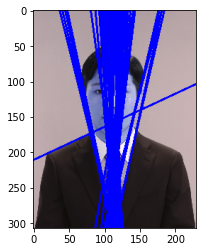

In [22]:
hough_lines('./data/images/image.jpg')

# 顔検出

In [89]:
def face_detect(image_path, resized_image):

    face_cascade_path = './haarcascades/haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(face_cascade_path)

    src = cv2.imread(image_path)
    src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(src_gray)

#     print("face:".format(faces)) # 左上x,左上y,width,height
        
    height, width, channels = resized_image.shape[:3]
    detect_area = [100, 700, height, 100]# [上,右,下,左]

    # 描画
    for x, y, w, h in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 0), 2)
        # 検出エリアを格納
        detect_area[0] = x + h
        # 顔幅の1.5倍幅までを分析
        detect_area[3] = x - (w*1.5)
        detect_area[1] = (x+w) + (w*1.5)
    
    if detect_area[3] < 100:
        detect_area[3] = 100
    
#     plt.imshow(src)

    return detect_area

# 瞳検出

In [87]:
face_cascade_path = './haarcascades/haarcascade_frontalface_default.xml'
eye_cascade_path = './haarcascades/haarcascade_eye.xml'

face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

src = cv2.imread('./data/images/Lenna_test.png')
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(src_gray)

# print(faces)

# 描画
for x, y, w, h in faces:
    cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 0), 2)
    face = src[y: y + h, x: x + w] # 顔面切り取り
    face_gray = src_gray[y: y + h, x: x + w]
    eyes = eye_cascade.detectMultiScale(face_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(face, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

# cv2.imwrite('./output/opencv_face_detect_rectangle.jpg', src)

# テスト

[]
[]
検出できなかった


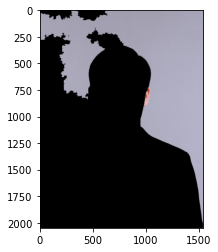

In [94]:
result = detect_shoulder('./data/images/image.jpg')
print(result)

[]
[]
検出できなかった


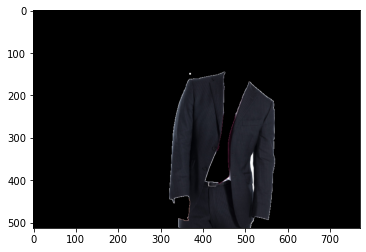

In [95]:
result = detect_shoulder('./data/images/test.jpg')
print(result)

face:
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 7

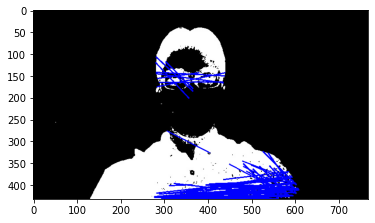

In [27]:
result = detect_shoulder('./data/images/diff.jpg')
print(result)

face:
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[560 335 613 405  53  70]
[100, 700, 432, 100]
[399 276 559 335 160  59]
[100, 700, 432, 100]
[248 320 331 277  83 -43]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[178 353 230 336  52 -17]
[100, 700, 432, 100]
[100, 700, 432, 100]
[400 275 553 330 153  55]
[100, 700, 432, 100]
[568 342 626 428  58  86]
[ 53. 160.  83.  52. 153.  58.]
[70. 59. 43. 17. 55. 86.]
検出できなかった


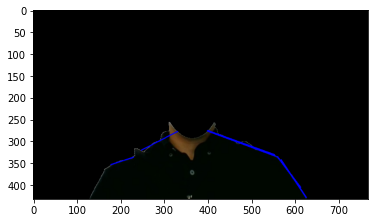

In [28]:
result = detect_shoulder('./data/images/final_img.png')
print(result)

face:
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 700, 432, 100]
[100, 7

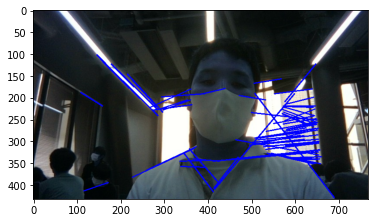

In [29]:
result = detect_shoulder('./data/images/20201120_110619.jpg')
print(result)

# 頭頂部を検出する

In [30]:
# 画素値？で検索　見つけた時点でreturn
# 違う色（白）のx座標を取得

# detect_area内の
# hough lineとx座標を比較
# hough lineが大きいとき小さいときそれぞれ
# hough line同士でy座標の比較
# 大きいとき小さいときそれぞれ一番y座標が小さいhough line をreturn

```python
img[100,100]
```
は各画素にアクセスするのに向いてない
ので、

```python
img.item()
# おそらく item(y, x, BGR)
```
を使う

In [31]:
def search_head(img):
    headpoint = []
    for y in range(5,50) :
        for x in range(150,500):
            if(img.item(y,x) > 50):
                headpoint = [y,x]
                return headpoint

In [32]:
resized_image, gray_image = color_to_gray('./data/images/diff.jpg')
headpoint = search_head(gray_image) #(y, x)

In [33]:
print(headpoint[1])#headpoint[0]: y, headpoint[1]: x

338


In [34]:
#顔下- 0-x

In [35]:
for y in range(detect_area[3], 400):
    for x in  range(0, headpoint[1]):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-35-5af9800ff4a5>, line 3)

In [39]:

class Shoulder(object):
    def __init__(self, img):
        self.color_image = img
        self.gray_image = None
        self.canny_image = None
        self.detect_area = []
        self.hough_lines = []

    def get_gray_image(self):
        self.gray_image = cv2.cvtColor(self.color_image, cv2.COLOR_BGR2GRAY)
    
    # canny変換
    def convert_canny_image(self):
        self.canny_image = cv2.Canny(self.gray_image, 50, 110)

    # 確率的ハフ変換
    def hough_lines_p(self):
        self.hough_lines = cv2.HoughLinesP(
            self.canny_image, rho=1, theta=np.pi/360, threshold=50, minLineLength=80, maxLineGap=10
        )
    
    def detect_area_line(self, line):
        print(line)
        x1, y1, x2, y2 = line[0]
        xa = (x2-x1)
        ya = (y2-y1)

        # 画面サイズを取得
        height, width, channels = MyImage.get_size(self.color_image)

        # 長すぎる直線を除く
        if xa > (width/2):
            return "false"
        # 上部の直線を除く
        if y1<detect_area[0] or y2<self.detect_area[0]:
            return "false"
        # 右部の直線を除く
        if x1>detect_area[1] or x2>self.detect_area[1]:
            return "false"
        # 下部の直線を除く
        if y1>detect_area[2] or y2>self.detect_area[2]:
            return "false"
        # 左部の直線を除く
        if x1<detect_area[3] or x2<self.detect_area[3]:
            return "false"
        # x方向に短すぎる直線を除く
        if xa < 50:
            return "false"
        return "true"

    # 結果
    def detect(self):
        self.gray_image = cv2.cvtColor(self.color_image, cv2.COLOR_BGR2GRAY)
        self.canny_image = cv2.Canny(self.gray_image, 50, 110)
        self.hough_lines = cv2.HoughLinesP(
            self.canny_image, rho=1, theta=np.pi/360, threshold=50, minLineLength=80, maxLineGap=10
        )
        xline = []
        yline = []
        for line in self.hough_lines:
            # 描画条件
            is_range = self.detect_area_line(line)
            if is_range=="true":
                cv2.line(self.color_image,(x1,y1),(x2,y2),(0,0,255),2) # 描画

                line = np.append(line, [xa,ya])
                # 負の数を正の数に変換
                if(xa < 0):
                    xa = -xa
                if(ya < 0):
                    ya = -ya
                xline =np.append(xline, xa)
                yline =np.append(yline, ya)
        # 描画後の画像保存
        save_path = MyImage.save(self.color_image)
        # ここかえたい
        if (len(xline) != 2 or len(yline) != 2):
            result = "検出できませんでした。"
        else:
            if (yline[0]-yline[1] > 10) or (yline[0]-yline[1] < -10):
                result = "傾むいてます。"
            elif (xline[0]-xline[1] > 10) or (xline[0]-xline[1] < -10):
                result = "回転してます。"
            else:
                result = "OK"
        return result, save_path

In [40]:
img = cv2.imread('./data/images/diff.jpg')
shoulder = Shoulder(img)
result, save_path = shoulder.detect()

[[451 412 572 406]]


NameError: name 'detect_area' is not defined

In [41]:
import numpy as np
import cv2
import random
import os
import datetime
import string

SAVE_DIR = "./static/images/"

class MyImage(object):
    # 画像を保存する
    def save(img):
        now = datetime.datetime.now()
        img_name = now.strftime('%Y%m%d_%H%M%S') + '.jpg'
        save_path = os.path.join(SAVE_DIR, img_name)
        cv2.imwrite(save_path, img)
        return save_path

    def get_size(img):
        height, width, channels = img.shape[:3]
        return height, width, channels

In [91]:
def remove_background(img_path):
    img = cv2.imread(img_path)
    # ゼロの空白画像を作成（imgと同じ寸法)
    marker = np.zeros_like(img[:,:,0]).astype(np.int32)
    # 背景部分を１で指定
    # 手動でポイントを一つ一つ指定
    marker[430][110] = 1
    marker[308][164] = 1
    marker[246][270] = 1
    marker[32][268] = 1
    marker[32][451] = 1
    marker[264][451] = 1
    marker[324][579] = 1
    marker[430][640] = 1
    # 切り取りたいパーツを指定
    # 体とマスクと顔を色分けして分かりやすくしてる
    marker[430][370] = 255    # body
    marker[200][370] = 125    # mask
    marker[150][370] = 62    # face

    # マークされた画像を生成するアルゴリズム
    marked = cv2.watershed(img, marker)
    # 背景を黒にして、白にしたいものは白にする
    marked[marked == 1] = 0
    marked[marked > 1] = 255
    # 3×3ピクセルのカーネルを使用して画像を薄くし、輪郭のディテールを失わないようにする
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(marked.astype(np.float32), kernel, iterations = 1)
#     plt.imshow(dilation, 'gray')
#     print(dilation.shape)
#     return dilation
#     # 最初の画像に作成したマスクを適用
    final_img = cv2.bitwise_and(img, img, mask=dilation.astype(np.uint8))
    # BGR を RGB に変換することで、正確な色で画像を描画
    b, g, r = cv2.split(final_img)
    final_img = cv2.merge([r, g, b])
#     plt.imshow(final_img)
    return final_img

(432, 768)


(432, 768)

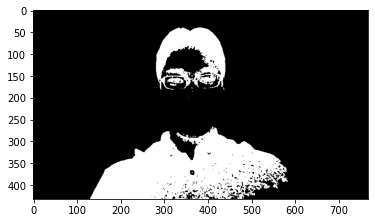

In [57]:
img=cv2.imread('./data/images/diff.jpg')
gray_image = remove_background(img)
gray_image = cv2.cvtColor(gray_image,cv2.COLOR_BGR2GRAY)
gray_image.shape

In [96]:
img=cv2.imread('./flaskapp/static/images/20201210_104513.jpg')
gray_image = remove_background(img)
gray_image = cv2.cvtColor(gray_image,cv2.COLOR_BGR2GRAY)
gray_image.shape

TypeError: bad argument type for built-in operation

In [71]:
canny_image = cv2.Canny(gray_image, 50, 110)

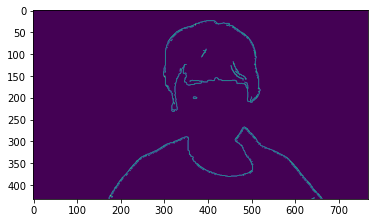

In [72]:
plt.imshow(canny_image)

In [73]:
cv2.HoughLinesP(canny_image, rho=1, theta=np.pi/360, threshold=45, minLineLength=40, maxLineGap=30)

array([[[581, 336, 662, 430]],

       [[303, 170, 303,  92]],

       [[199, 389, 242, 341]],

       [[249, 335, 350, 289]],

       [[586, 340, 661, 428]],

       [[328, 161, 465, 161]],

       [[579, 335, 659, 430]],

       [[191, 403, 250, 335]]], dtype=int32)

# 背景削除

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 画像読み込み
def background1(img):

    # ゼロの空白画像を作成（imgと同じ寸法)
    marker = np.zeros_like(img[:,:,0]).astype(np.int32)



    # 背景部分を１で指定
    # 手動でポイントを一つ一つ指定
    marker[431][133] = 1
    marker[414][134] = 1
    marker[402][136] = 1
    marker[389][140] = 1
    marker[373][147] = 1
    marker[355][160] = 1
    marker[341][175] = 1
    marker[328][194] = 1
    marker[315][228] = 1
    marker[307][253] = 1
    marker[303][278] = 1
    marker[300][294] = 1
    #--------------------ここまで左肩
    #--------------------ここから頭
    marker[273][296] = 1
    marker[235][280] = 1
    marker[202][275] = 1
    marker[168][276] = 1
    marker[146][283] = 1
    marker[110][304] = 1
    marker[84][331] = 1
    marker[74][363] = 1
    marker[71][381] = 1 #頂点
    marker[74][399] = 1
    marker[84][431] = 1
    marker[110][458] = 1
    marker[168][479] = 1
    marker[202][486] = 1
    marker[146][487] = 1
    marker[235][482] = 1
    marker[273][466] = 1
    #-------------------ここまで頭
    #-------------------ここから右肩
    marker[300][468] = 1
    marker[303][484] = 1
    marker[307][509] = 1
    marker[315][524] = 1
    marker[328][558] = 1
    marker[341][577] = 1
    marker[355][592] = 1
    marker[373][605] = 1
    marker[389][612] = 1
    marker[402][616] = 1
    marker[414][618] = 1
    marker[431][619] = 1

    # 切り取りたいパーツを指定
    # 体とマスクと顔を色分けして分かりやすくしてる
    marker[391][456] = 255    # suit
    marker[352][362] = 125    # shirt
    marker[250][378] = 62     # face
    marker[121][378] = 31     # head



    # マークされた画像を生成するアルゴリズム
    marked = cv2.watershed(img, marker)

    # プロット
#     plt.imshow(marked, cmap='gray')
    #plt.show() 確認用

    # 背景を黒にして、白にしたいものは白にする
    marked[marked == 1] = 0
    marked[marked > 1] = 255

    # 5×5ピクセルのカーネルを使用して画像を薄くし、輪郭のディテールを失わないようにする
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(marked.astype(np.float32), kernel, iterations = 1)

    # もう一度プロットして 拡張が必要に応じているかどうかを確認
    # そうでなければ, カーネルを小さくしたり大きくしたり, 反復回数を多くしたり少なくしたりしてを繰り返す。
#     plt.imshow(dilation, cmap='gray')
    #plt.show() 確認用

    # 最初の画像に作成したマスクを適用
    final_img = cv2.bitwise_and(img, img, mask=dilation.astype(np.uint8))

    # BGR を RGB に変換することで、正確な色で画像を描画
    b, g, r = cv2.split(final_img)
    final_img = cv2.merge([r, g, b])

    # 最終的な結果をプロットする
#     plt.imshow(final_img)
#     plt.show()
    return final_img

    # #RGBに戻して画像保存
    # im_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    # cv2.imwrite('./final_img.png', im_rgb)

array([[[531, 347, 590, 431]],

       [[261, 363, 392, 299]],

       [[536, 351, 579, 411]],

       [[338, 255, 418, 136]],

       [[222, 430, 267, 358]],

       [[425, 314, 529, 346]],

       [[224, 424, 260, 364]],

       [[269, 357, 391, 297]],

       [[395, 301, 517, 341]],

       [[533, 348, 584, 419]],

       [[540, 360, 586, 427]],

       [[451, 268, 453, 191]],

       [[340, 232, 357, 344]],

       [[395, 123, 410, 359]],

       [[431, 346, 456, 204]],

       [[329, 254, 373, 183]],

       [[384, 246, 450, 180]],

       [[436, 305, 455, 196]],

       [[222, 428, 266, 359]]], dtype=int32)

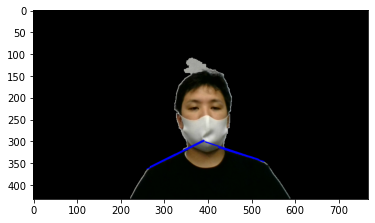

In [118]:
detect_area = [250, 600, 400, 100]
img = cv2.imread('./data/images/sample2.png')
color_image = background1(img)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
canny_image = cv2.Canny(gray_image, 50, 110)
hough_lines_p(color_image, canny_image, detect_area)

array([[[221, 355, 342, 298]],

       [[540, 356, 574, 430]],

       [[353, 173, 414, 234]],

       [[293, 191, 390, 189]],

       [[297, 220, 486, 207]],

       [[328, 284, 331, 360]],

       [[414, 293, 535, 351]],

       [[386, 187, 488, 188]],

       [[413, 380, 439, 225]],

       [[377, 279, 385, 167]],

       [[409, 386, 460, 179]],

       [[188, 429, 217, 360]],

       [[310, 242, 487, 198]],

       [[295, 212, 447, 239]],

       [[218, 359, 269, 329]],

       [[541, 357, 574, 428]],

       [[241, 342, 329, 303]],

       [[296, 216, 489, 192]],

       [[442, 139, 475, 210]],

       [[414, 297, 483, 328]],

       [[368, 170, 427, 235]],

       [[306, 227, 348, 400]],

       [[433, 256, 461, 190]],

       [[193, 410, 211, 369]],

       [[307, 140, 392, 220]],

       [[317, 265, 402, 162]],

       [[377, 170, 441, 245]],

       [[295, 211, 437, 206]],

       [[402, 326, 471, 193]],

       [[545, 363, 574, 426]],

       [[293, 186, 346, 186]],

       [

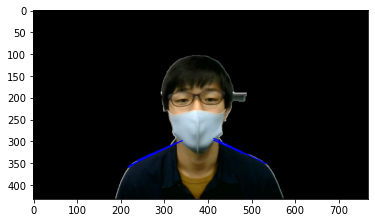

In [121]:
detect_area = [250, 600, 400, 100]
img = cv2.imread('./data/images/sample3.png')
color_image = background1(img)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
canny_image = cv2.Canny(gray_image, 50, 110)
hough_lines_p(color_image, canny_image, detect_area)

array([[[515, 340, 559, 416]],

       [[538, 383, 562, 425]],

       [[273, 327, 444, 210]],

       [[318, 231, 460, 311]],

       [[215, 356, 446, 220]],

       [[409, 285, 484, 328]],

       [[336, 276, 445, 197]],

       [[321, 203, 475, 328]],

       [[253, 337, 445, 205]],

       [[333, 264, 437, 144]],

       [[327, 154, 436, 263]],

       [[356, 163, 392, 114]],

       [[327, 148, 435, 260]],

       [[320, 168, 343, 290]],

       [[344, 124, 438, 245]],

       [[272, 327, 444, 209]],

       [[324, 248, 447, 187]],

       [[199, 387, 232, 337]],

       [[331, 138, 438, 256]],

       [[331, 192, 383, 117]],

       [[346, 121, 369, 306]],

       [[336, 131, 365, 304]],

       [[402, 115, 423, 327]],

       [[370, 113, 377, 310]],

       [[335, 173, 362, 302]],

       [[349, 119, 370, 307]],

       [[321, 295, 447, 169]],

       [[295, 310, 441, 238]],

       [[320, 177, 354, 295]],

       [[324, 155, 385, 216]],

       [[329, 142, 435, 258]],

       [

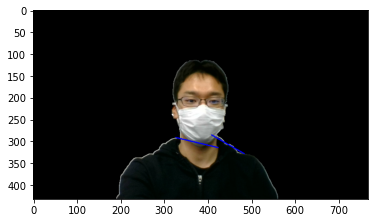

In [120]:
detect_area = [250, 600, 400, 100]
img = cv2.imread('./data/images/sample4.png')
color_image = background1(img)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
canny_image = cv2.Canny(gray_image, 50, 110)
hough_lines_p(color_image, canny_image, detect_area)